# Loop model params :-)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy.random import seed # to set seed
from tensorflow.random import set_seed # to set seed
import pandas as pd
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

## Setting seed

In [3]:
# Apply seed
seed_value = 1338
set_seed(seed_value)
seed(seed_value)

## ?

In [4]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [ ]:
#conda activate -n gpu2

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
tf.test.is_built_with_cuda()

True

## Image generator

In [7]:
# Kopieret fra model_2.py 4/11 ~~11.30
#%% ImageDataGenerator

image_size = [200, 200]
batch = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip= True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_gen = train_datagen.flow_from_directory(
    'train',
    target_size=image_size,
    batch_size=batch,
    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = test_datagen.flow_from_directory(
        'val',
        target_size=image_size,
        batch_size=batch,
        class_mode='binary')

test_gen = test_datagen.flow_from_directory(
    'test',
    target_size=image_size,
    batch_size=batch,
    class_mode='binary')

#%% Visualizing ImageDataGenerator augmentation
train_datagen_viz = ImageDataGenerator(rotation_range=40,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip= True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_gen_viz = train_datagen_viz.flow_from_directory(
    'train',
    target_size=image_size,
    color_mode='rgb',
    batch_size=1,
    class_mode='binary',
    seed=1337)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_gen_viz)[0].astype('uint8')
    
    image = np.squeeze(image)
    
    ax[i].imshow(image)
    ax[i].axis('off')

Found 2076 images belonging to 2 classes.
Found 258 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Found 2076 images belonging to 2 classes.


## Loop

In [8]:
# Units
con_layer_1 = [16]
con_layer_2 = [32]
con_layer_3 = [32]
act_funcs = ['relu', 'selu', 'elu', 'tanh', 'sigmoid']
hidden_layer_1 = [512]
dropout_sizes = [0.2]
optimizers = ["adam", "sgd"]
epoch_n = 10

In [ ]:
# Units for single test
#con_layer_1 = [32]
#con_layer_2 = [32]
#con_layer_3 = [32]
#act_funcs = ['relu']
#hidden_layer_1 = [256]
#dropout_sizes = [0.1]
#optimizers = ["adam"]
#epoch_n = 10

In [9]:
# Number of models to be created:
model_count = len(con_layer_1) * len(con_layer_2) * len(con_layer_3) * len(act_funcs) * len(act_funcs) * len(act_funcs) * len(act_funcs) * len(dropout_sizes) * len(optimizers) * len(hidden_layer_1)

# Result array
results = pd.DataFrame(columns = ['loss',
                                  'val_loss',
                                  'accuracy',
                                  'val_accuracy',
                                  'con_layer_1',
                                  'con_layer_1_activation',
                                  'con_layer_2',
                                  'con_layer_2_activation',
                                  'con_layer_3',
                                  'con_layer_3_activation',
                                  'hidden_layer_1',
                                  'hidden_layer_1_activation',
                                  'dropout_sizes',
                                  'optimizers',
                                  'epoch',
                                  'epoch_n'])
print(f"There are {model_count} parameter combinations and {epoch_n} epochs")

There are 1250 parameter combinations and 10 epochs


In [10]:
# Load results
results = pd.read_csv('loop_results.csv')
#results

In [14]:
# Loop tracking
count = 0 # To count loops
# Model loop
for con1 in con_layer_1:
    for con1_act in act_funcs:
        for con2 in con_layer_2:
            if(con1*3<con2):
                continue
            for con2_act in act_funcs:
                for con3 in con_layer_3:
                    if(con2*3<con3):
                        continue
                    for con3_act in act_funcs:
                        for hidden1 in hidden_layer_1:
                            for hidden1_act in act_funcs:
                                for dropout_size in dropout_sizes:
                                    for optimizer in optimizers:
                                        # Count and print progress
                                        count = count+1
                                        
                                        
                                        # Check if combination has been used
                                        if(len(results.loc[(results['con_layer_1'] == con1) &
                                                           (results['con_layer_1_activation'] <= con1_act) &
                                                           (results['con_layer_2'] == con2) &
                                                           (results['con_layer_2_activation'] == con2_act) &
                                                           (results['con_layer_3'] == con3) &
                                                           (results['con_layer_3_activation'] == con3_act) &
                                                           (results['hidden_layer_1'] == hidden1) &
                                                           (results['hidden_layer_1_activation'] == hidden1_act) &
                                                           (results['dropout_sizes'] == dropout_size) &
                                                           (results['optimizers'] == optimizer) &
                                                           (results['epoch_n'] <= epoch_n)])):
                                            print(f"Skipped model {count} out of {model_count}.")
                                            continue
                                        else:
                                            print(f'Training model {count} out of {model_count}.')
                                        # Model baseret på model.py kopieret 04/11 ~11.30
                                        model = keras.Sequential([
                                            # First convolution
                                            layers.Conv2D(con1, (3,3), activation=con1_act, input_shape=(200, 200, 3)),
                                            layers.MaxPooling2D(2,2), # halving the image size 

                                            # Second convolution
                                            layers.Conv2D(con2, (3,3), activation=con2_act),
                                            layers.MaxPooling2D(2,2),

                                            # Third convolution
                                            layers.Conv2D(con3, (3,3), activation=con3_act),
                                            layers.MaxPooling2D(2,2),

                                            # Fourth convolution - hidden until after some finetuning
                                            #layers.Conv2D(64, (3,3), activation='relu'),
                                            #layers.MaxPooling2D(2,2),

                                            # Fifth convolution - hidden until after some finetuning
                                            #layers.Conv2D(64, (3,3), activation='relu'),
                                            #layers.MaxPooling2D(2,2),

                                            # Flatten results to feed into a Deep Nerual Net
                                            layers.Flatten(),

                                            # 512 neuron hidden layer
                                            layers.Dense(hidden1, activation=hidden1_act),
                                            
                                            # Dropout NEW!!!!!!
                                            layers.Dropout(dropout_size),

                                            # Binary output layer
                                            layers.Dense(1, activation='sigmoid')
                                            ])

                                        #model.summary() # model summary

                                        model.compile(
                                            loss='binary_crossentropy',
                                            optimizer=optimizer,
                                            metrics=['accuracy']) # compiling model
                                        
                                        # Model fitting fra model_2.py kopieret 4/11 ~11.30
                                        # Callbacks for tensorboard 
                                        tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs") # tensorboard --logdir ./logs

                                        # Step sizes for train, validation and testing
                                        STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
                                        STEP_SIZE_VAL=val_gen.n//val_gen.batch_size
                                        STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

                                        # Fitting model
                                        history = model.fit(
                                            train_gen,
                                            steps_per_epoch=STEP_SIZE_TRAIN,
                                            epochs=epoch_n, # for at spare lidt tid
                                            validation_data=val_gen,
                                            validation_steps=STEP_SIZE_VAL,
                                            callbacks=[tensorboard_callback],
                                            verbose = False)
                                        
                                        # Get results (from history)
                                        history = history.history
                                        
                                        # Append each epoch
                                        for h in range(len(history['loss'])):
                                            row = {'loss':history['loss'][h],
                                                   'val_loss':history['val_loss'][h],
                                                   'accuracy':history['accuracy'][h],
                                                   'val_accuracy': history['val_accuracy'][h],
                                                   'con_layer_1': con1,
                                                   'con_layer_1_activation': con1_act,
                                                   'con_layer_2': con2,
                                                   'con_layer_2_activation': con2_act,
                                                   'con_layer_3': con3,
                                                   'con_layer_3_activation': con3_act,
                                                   'hidden_layer_1': hidden1,
                                                   'hidden_layer_1_activation': hidden1_act,
                                                   'dropout_sizes': dropout_size,
                                                   'optimizers': optimizer,
                                                   'epoch': (h+1),
                                                   'epoch_n': epoch_n}
                                            results = results.append(row, ignore_index=True)
                                        # Save model
                                        results.to_csv('loop_results.csv',index=False)

print("All done")

Skipped model 1 out of 250.
Skipped model 2 out of 250.
Skipped model 3 out of 250.
Skipped model 4 out of 250.
Skipped model 5 out of 250.
Skipped model 6 out of 250.
Skipped model 7 out of 250.
Skipped model 8 out of 250.
Skipped model 9 out of 250.
Skipped model 10 out of 250.
Skipped model 11 out of 250.
Skipped model 12 out of 250.
Skipped model 13 out of 250.
Skipped model 14 out of 250.
Skipped model 15 out of 250.
Skipped model 16 out of 250.
Skipped model 17 out of 250.
Skipped model 18 out of 250.
Skipped model 19 out of 250.
Skipped model 20 out of 250.
Skipped model 21 out of 250.
Skipped model 22 out of 250.
Skipped model 23 out of 250.
Skipped model 24 out of 250.
Skipped model 25 out of 250.
Skipped model 26 out of 250.
Skipped model 27 out of 250.
Skipped model 28 out of 250.
Skipped model 29 out of 250.
Skipped model 30 out of 250.
Skipped model 31 out of 250.
Skipped model 32 out of 250.
Skipped model 33 out of 250.
Skipped model 34 out of 250.
Skipped model 35 out of

KeyboardInterrupt: 

In [15]:
# Save model
results.to_csv('loop_results.csv',index=False)

In [ ]:
#results

## Bedste performende

In [18]:
best_results20 = results.nlargest(20, 'val_accuracy')
best_results20

,loss,val_loss,accuracy,val_accuracy,con_layer_1,con_layer_1_activation,con_layer_2,con_layer_2_activation,con_layer_3,con_layer_3_activation,hidden_layer_1,hidden_layer_1_activation,dropout_sizes,optimizers,epoch,epoch_n
338,0.6141682863235474,0.556110,0.665851,0.738281,16.0,relu,32.0,relu,32.0,elu,512.0,sigmoid,0.2,adam,9.0,10.0
337,0.6048719882965088,0.571552,0.677593,0.722656,16.0,relu,32.0,relu,32.0,elu,512.0,sigmoid,0.2,adam,8.0,10.0
3609,0.6320818066596985,0.603962,0.642368,0.722656,16.0,elu,32.0,tanh,32.0,elu,512.0,sigmoid,0.2,adam,10.0,10.0
2868,0.5908870100975037,0.567517,0.685910,0.718750,16.0,elu,32.0,relu,32.0,tanh,512.0,relu,0.2,adam,9.0,10.0
2889,0.6427200436592102,0.582451,0.634540,0.710938,16.0,elu,32.0,relu,32.0,tanh,512.0,elu,0.2,adam,10.0,10.0
3558,0.6269457340240479,0.600647,0.648239,0.710938,16.0,elu,32.0,tanh,32.0,selu,512.0,sigmoid,0.2,adam,9.0,10.0
197,0.6173581480979919,0.572943,0.663405,0.707031,16.0,relu,32.0,relu,32.0,selu,512.0,elu,0.2,adam,8.0,10.0
638,0.5910580158233643,0.572047,0.685910,0.707031,16.0,relu,32.0,relu,64.0,relu,512.0,sigmoid,0.2,adam,9.0,10.0
1509,0.611839771270752,0.611841,0.673190,0.707031,16.0,relu,32.0,elu,32.0,tanh,512.0,selu,0.2,adam,10.0,10.0
2838,0.5863400101661682,0.550622,0.684932,0.707031,16.0,elu,32.0,relu,32.0,elu,512.0,elu,0.2,adam,9.0,10.0


#### Feature search

In [72]:
best_results100 = results.nlargest(100, 'val_accuracy')
best_results100 = best_results100.filter(items=["con_layer_1", "con_layer_1_activation", "con_layer_2", "con_layer_2_activation", "con_layer_3", "con_layer_3_activation", "hidden_layer_1", "hidden_layer_1_activation", "dropout_sizes", "optimizers"])
plt.close('all')

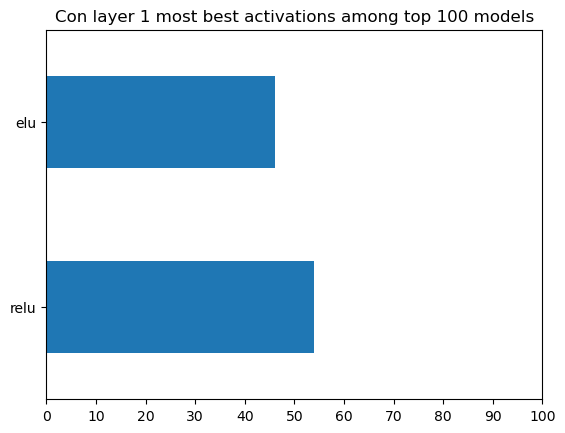

In [76]:
# Most used con_layer_1_activation of top 100
#best_results_con_layer_1_activation = best_results100["con_layer_1_activation"].value_counts(normalize=True)
best_results100['con_layer_1_activation'].value_counts()[:100].plot(kind='barh')
plt.xticks(np.arange(0, 101, 10))
plt.title("Con layer 1 most best activations among top 100 models")
plt.show()


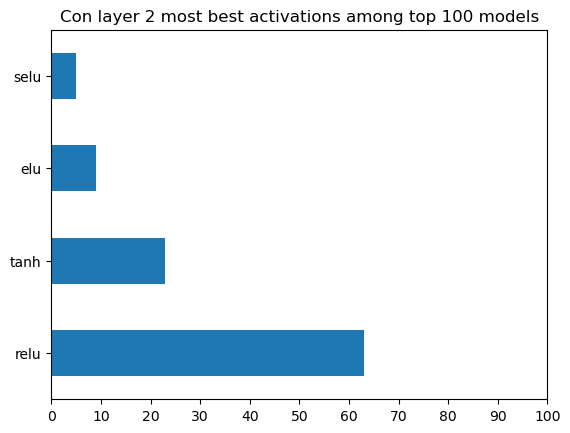

In [77]:
# Most used con_layer_2_activation of top 100
#best_results_con_layer_2_activation = best_results100["con_layer_2_activation"].value_counts(normalize=True)
best_results100['con_layer_2_activation'].value_counts()[:100].plot(kind='barh')
plt.xticks(np.arange(0, 101, 10))
plt.title("Con layer 2 most best activations among top 100 models")
plt.show()

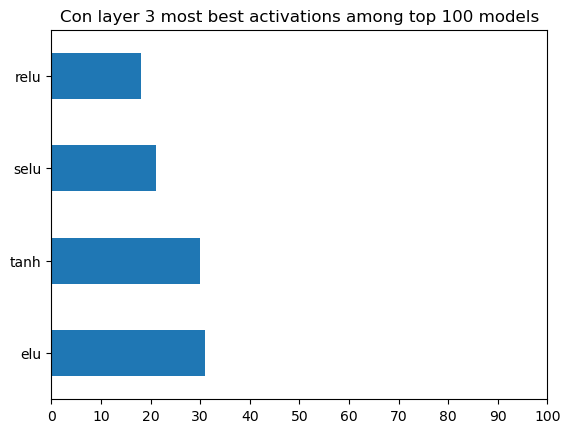

In [78]:
# Most used con_layer_3_activation of top 100
#best_results_con_layer_3_activation = best_results100["con_layer_3_activation"].value_counts(normalize=True)
best_results100['con_layer_3_activation'].value_counts()[:100].plot(kind='barh')
plt.xticks(np.arange(0, 101, 10))
plt.title("Con layer 3 most best activations among top 100 models")
plt.show()

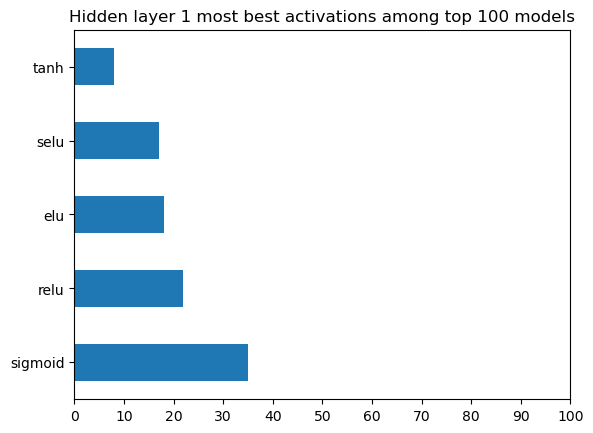

In [79]:
# Most used hidden_layer_1_activation of top 100
#best_results_hidden_layer_1_activation = best_results100["hidden_layer_1_activation"].value_counts(normalize=True)
best_results100['hidden_layer_1_activation'].value_counts()[:100].plot(kind='barh')
plt.xticks(np.arange(0, 101, 10))
plt.title("Hidden layer 1 most best activations among top 100 models")
plt.show()

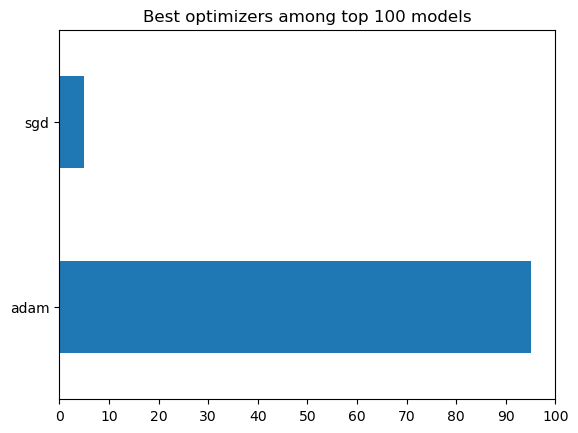

In [80]:
# Most used optimizers of top 100
#best_results_optimizers = best_results100["optimizers"].value_counts(normalize=True)
best_results100['optimizers'].value_counts()[:100].plot(kind='barh')
plt.xticks(np.arange(0, 101, 10))
plt.title("Best optimizers among top 100 models")
plt.show()

## Modeller med potentialle for at kunne nå bedre potentialle med flere epoch:


In [23]:
results_gowing = results.sort_values(by=['val_accuracy', 'accuracy'], ascending=False)
results_gowing = results_gowing[results_gowing["epoch"] == 10]

results_gowing.head(20)

,loss,val_loss,accuracy,val_accuracy,con_layer_1,con_layer_1_activation,con_layer_2,con_layer_2_activation,con_layer_3,con_layer_3_activation,hidden_layer_1,hidden_layer_1_activation,dropout_sizes,optimizers,epoch,epoch_n
3609,0.6320818066596985,0.603962,0.642368,0.722656,16.0,elu,32.0,tanh,32.0,elu,512.0,sigmoid,0.2,adam,10.0,10.0
2889,0.6427200436592102,0.582451,0.634540,0.710938,16.0,elu,32.0,relu,32.0,tanh,512.0,elu,0.2,adam,10.0,10.0
1509,0.611839771270752,0.611841,0.673190,0.707031,16.0,relu,32.0,elu,32.0,tanh,512.0,selu,0.2,adam,10.0,10.0
3760,0.5808073878288269,0.569408,0.687867,0.703125,16.0,elu,32.0,relu,32.0,relu,512.0,sigmoid,0.2,adam,10.0,10.0
139,0.5971649885177612,0.579172,0.670254,0.699219,16.0,relu,32.0,relu,32.0,relu,512.0,sigmoid,0.2,adam,10.0,10.0
1469,0.6198923587799072,0.600580,0.669765,0.699219,16.0,relu,32.0,elu,32.0,elu,512.0,sigmoid,0.2,adam,10.0,10.0
4330,0.6368864178657532,0.631032,0.641879,0.699219,16.0,elu,32.0,elu,32.0,relu,512.0,selu,0.2,sgd,10.0,10.0
2879,0.6041741967201233,0.609449,0.670254,0.695312,16.0,elu,32.0,relu,32.0,tanh,512.0,selu,0.2,adam,10.0,10.0
3569,0.6270524263381958,0.601416,0.651174,0.695312,16.0,elu,32.0,tanh,32.0,elu,512.0,relu,0.2,adam,10.0,10.0
559,0.5799306631088257,0.568221,0.686399,0.691406,16.0,relu,32.0,relu,64.0,relu,512.0,relu,0.2,adam,10.0,10.0
